In [39]:
using AstroTime
using CSV
using DataFrames
using LinearAlgebra
using Measurements
using PyCall
using PyPlot
using SiriusB

┌ Info: Precompiling SiriusB [2a15530f-af1a-59c5-8974-53d43438f74d]
└ @ Base loading.jl:1317


In [42]:
orb = pyimport("orbitize")
driver = pyimport("orbitize.driver");

In [2]:
parallax = 376.6801e-3 # arcseconds
pxscale = 0.01; # arcseconds/px

## input data

In [150]:
fwhms = [
    7.985399074538929,
    7.644946278252633,
    8.216162087416189
]
errs = fwhms ./ 2;

In [151]:
# guesses from GreeDS outputs of three epochs
pos = [
    110.821 ± errs[1]  95.6414 ± errs[1];
    111.024 ± errs[2]  94.5881 ± errs[2];
    110.98 ± errs[3]  95.9881 ± errs[3];
] # px coordinates

3×2 Matrix{Measurement{Float64}}:
 110.8±4.0  95.6±4.0
 111.0±3.8  94.6±3.8
 111.0±4.1  96.0±4.1

In [152]:
# translate into offset and angle
center = [100.5 100.5]

delta = pos .- center

3×2 Matrix{Measurement{Float64}}:
 10.3±4.0  -4.9±4.0
 10.5±3.8  -5.9±3.8
 10.5±4.1  -4.5±4.1

In [153]:
dist = mapslices(norm, delta, dims=2) .* pxscale .* 1e3

3×1 Matrix{Measurement{Float64}}:
 114.0 ± 40.0
 121.0 ± 38.0
 114.0 ± 41.0

In [154]:
angs = mapslices(v -> atand(reverse(v)...) - 90, delta, dims=2)

3×1 Matrix{Measurement{Float64}}:
 -115.0 ± 20.0
 -119.0 ± 18.0
 -113.0 ± 21.0

In [155]:
epochs = [
    TTEpoch(2020, 2, 4),
    TTEpoch(2020, 11, 21),
    TTEpoch(2020, 11, 28)
]

3-element Vector{TTEpoch{Float64}}:
 2020-02-04T00:00:00.000 TT
 2020-11-21T00:00:00.000 TT
 2020-11-28T00:00:00.000 TT

In [156]:
epochs_mjd = modified_julian.(epochs) .|> value

3-element Vector{Float64}:
 58883.0
 59174.0
 59181.0

In [157]:
data_in = DataFrame(
    epoch = epochs_mjd,
    object = fill(1, length(epochs)),
    sep = Measurements.value.(dist) |> vec,
    sep_err = Measurements.uncertainty.(dist) |> vec,
    pa = Measurements.value.(angs) |> vec,
    pa_err = Measurements.uncertainty.(angs) |> vec
)

,epoch,object,sep,sep_err,pa,pa_err
,Float64,Int64,Float64,Float64,Float64,Float64
1,58883.0,1,114.074,39.927,-115.209,20.0541
2,59174.0,1,120.708,38.2247,-119.325,18.1439
3,59181.0,1,114.1,41.0808,-113.293,20.6289


In [123]:
data_in |> CSV.write(datadir("sirius-b_astrometry_data.csv"))

"/Users/miles/dev/research/sirius-b/src/../data/sirius-b_astrometry_data.csv"

In [158]:
mydriver = driver.Driver(
    datadir("sirius-b_astrometry_data.csv"),
    "OFTI",
    1, # number of bodies
    3.081, # total system mass M_sun https://iopscience.iop.org/article/10.3847/1538-4357/aa6af8/pdf
    0.3789e3, # parallax in mas https://iopscience.iop.org/article/10.3847/1538-4357/aa6af8/pdf
    mass_err = 0.034,
    plx_err = 0.0014e3
)

PyObject <orbitize.driver.Driver object at 0x15bb66d90>

In [165]:
s = mydriver.sampler
orbits = s.run_sampler(Int(1e6));

/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/kepler.py:82: RuntimeWarning: invalid value encountered in remainder
  manom = (mean_motion*(epochs[:, None] - tau_ref_epoch) - 2*np.pi*tau) % (2.0*np.pi)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/kepler.py:82: RuntimeWarning: invalid value encountered in remainder
  manom = (mean_motion*(epochs[:, None] - tau_ref_epoch) - 2*np.pi*tau) % (2.0*np.pi)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/units/quantit

In [167]:
s.results.plot_orbits(start_mjd=epochs_mjd[1])
# PyPlot.tight_layout()
savefig("/Users/miles/dev/research/sirius-b/paper/figures/orbit.pdf");

LoadError: PyError ($(Expr(:escape, :(ccall(#= /Users/miles/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Input values did not match the format class mjd:\nTypeError: Input values for mjd class must be finite doubles')
  File "/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/results.py", line 494, in plot_orbits
    vmin=np.min(Time(epochs, format='mjd').decimalyear),
  File "/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/time/core.py", line 1528, in __init__
    self._init_from_vals(val, val2, format, scale, copy,
  File "/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/time/core.py", line 372, in _init_from_vals
    self._time = self._get_time_fmt(val, val2, format, scale,
  File "/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/time/core.py", line 438, in _get_time_fmt
    raise ValueError(


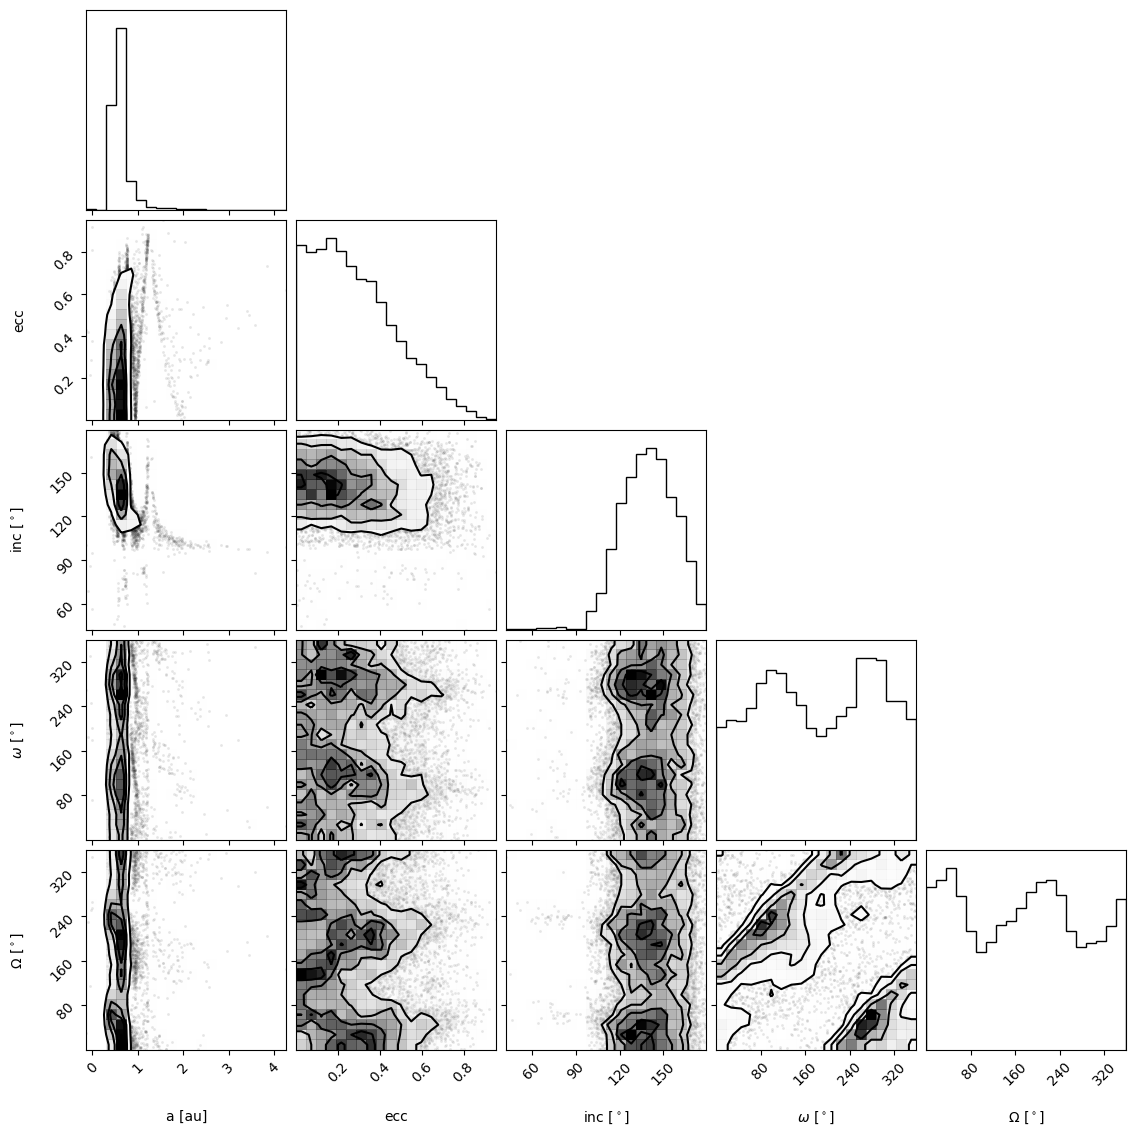

In [146]:
s.results.plot_corner(param_list=["sma1", "ecc1", "inc1", "aop1", "pan1","tau1"]);